In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from IPython.display import display
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "data"

In [3]:
# Hyperparameters
NUM_FRAMES = 5  # Number of frames to extract from the video
TIME_BETWEEN_FRAMES = 1  # Time between frames in seconds

In [4]:
train_csv_path = f"{DATA_DIR}/train.csv"
train_videos_folder = f"{DATA_DIR}/train/"

df = pd.read_csv(train_csv_path)
# df = df[df['target']==1]
df.head()

,id,time_of_event,time_of_alert,target
0,1924,NaN,NaN,0
1,822,19.5,18.633,1
2,1429,NaN,NaN,0
3,208,19.8,19.233,1
4,1904,NaN,NaN,0


In [5]:
class ImageDataset(Dataset):
    def __init__(self, data, videos_folder, transform=None):
        self.data = data
        self.videos_folder = videos_folder
        self.transform = transform  # Any image transformations (e.g., augmentations)
        self.num_frames = NUM_FRAMES
        self.time_between_frames = TIME_BETWEEN_FRAMES

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        vid_path = os.path.join(
            self.videos_folder, f"{str(int(row['id'])).zfill(5)}.mp4"
        )

        time = None if np.isnan(row["time_of_event"]) else row["time_of_event"]
        images = self.get_multiple_frames(vid_path, time)

        label = row["target"]

        # Apply transformations
        if self.transform:
            images = [self.transform(image) for image in images]

        return images, torch.tensor(label), row["id"]  # Convert label to tensor

    def get_frame(self, video_path, time):
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_MSEC, time * 1000)

        success, frame = cap.read()
        cap.release()

        if not success:
            raise ValueError(f"Failed to read frame at {time} seconds.")

        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return Image.fromarray(frame)

    def get_multiple_frames(self, video_path, time):
        if time is None:
            # Get the last frames
            cap = cv2.VideoCapture(video_path)
            cap.set(cv2.CAP_PROP_POS_AVI_RATIO, 1)
            time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000
            cap.release()

        frames = []
        for i in range(self.num_frames):
            try:
                frame = self.get_frame(video_path, time - i * self.time_between_frames)
                frames.append(frame)
            except ValueError:
                break
        return frames


transform = transforms.Compose(
    [
        transforms.Resize((480, 854)),  # Resize to a standard size
    ]
)

dataset = ImageDataset(df, train_videos_folder, transform=transform)
dataloader = DataLoader(dataset, shuffle=True)

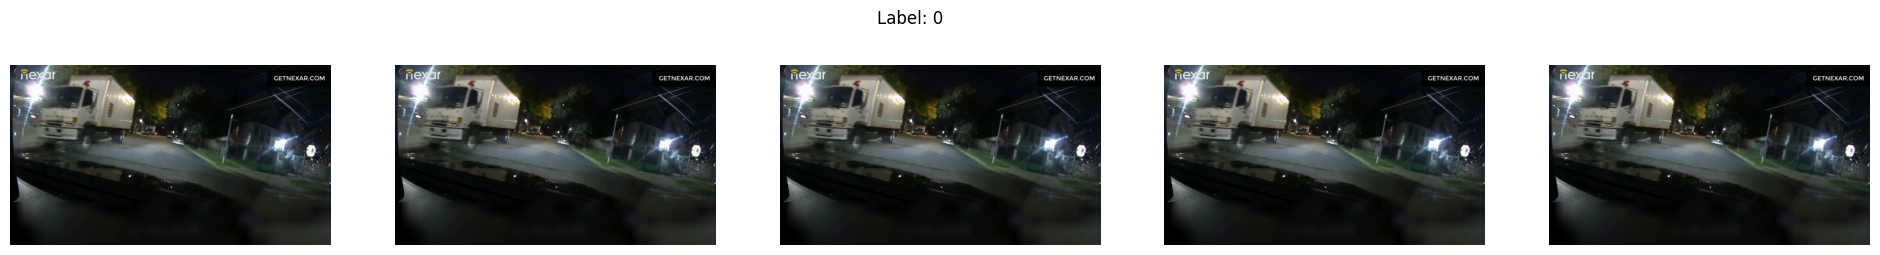

In [6]:
images, label, _ = dataset[np.random.randint(0, len(dataset))]
fig, axes = plt.subplots(1, len(images), figsize=(24, 3))
for i, image in enumerate(images):
    axes[i].imshow(image)
    axes[i].axis("off")
plt.suptitle(f"Label: {int(label)}")
plt.show()

In [ ]:
def get_llm_prompt(label):
    instruction = f"""
    You are an expert in accident reconstruction and traffic analysis. You will analyze a sequence of dashcam images with a chain of thought reasoning to determine whether there is an immediate threat of vehicle collision. In this particular scenario, there was {"a collision" if label else "no collision"}. Consider each of the following factors:

    1. Vehicle Positions: Identify the locations of all vehicles in each frame and how they change over time.
    2. Trajectories: Determine the direction, speed, and acceleration of each vehicle by comparing their positions across frames.
    3. Nearby Vehicles and Traffic: Identify surrounding vehicles, pedestrians, and any traffic congestion that could impact movement.
    4. Traffic Signals: Consider whether traffic signals indicate a stop, go, or caution state and how that affects the vehicle interactions. Pay special attention on whether vehicles are vialating or obeying traffic signal rules.
    5. Road Conditions and Visibility: Note any obstructions, road markings, or weather conditions that could contribute to the situation.
    """

    return instruction


def convert_to_conversation(images, label):
    # Combine all images into a single conversation
    conversation = [
        {
            "role": "system",
            "content": [
                {"type": "text", "text": get_llm_prompt(int(label))},
                *[{"type": "image", "image": img} for img in images],
            ],
        }
    ]
    return {"messages": conversation}


converted_dataset = [
    convert_to_conversation(image, label) for image, label, _ in tqdm(dataset)
]